Import necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import matplotlib.pyplot as plt
import random
import cv2
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm
import torch.optim as optim
import numpy as np
from PIL import Image
from torchvision import datasets, transforms, models
import os
from torch.utils.data import Dataset
import pandas as pd
import copy

Some necessary settings (GPU)

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)

# define class names
classes = ('A', 'B', 'C')

# define the path to the dataset
path_dataset = "dataset_beam/"

You are using device: cuda
You are using PyTorch version: 2.6.0+cu124


Data loading and processing

Edge detection function using morphological operations (Dilation and Erosion)

In [ ]:
def compute_mean_std(image_dir):
    """
    Compute the mean and standard deviation of images in a directory.
    Args:
        image_dir (str): Root directory containing class subfolders of images
    Returns:
        mean (tuple): Mean of R, G, B channels
        std (tuple): Standard deviation of R, G, B channels
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a consistent size
        transforms.ToTensor()           # Convert to [0, 1] and shape (C, H, W)
    ])

    image_paths = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images.")

    channel_sum = np.zeros(3)
    channel_squared_sum = np.zeros(3)
    num_pixels = 0

    for path in tqdm(image_paths, desc="Computing mean & std"):
        image = Image.open(path).convert("RGB")
        image_tensor = transform(image)
        np_image = image_tensor.numpy()

        channel_sum += np_image.sum(axis=(1, 2))
        channel_squared_sum += (np_image ** 2).sum(axis=(1, 2))
        num_pixels += np_image.shape[1] * np_image.shape[2]

    mean = channel_sum / num_pixels
    std = np.sqrt(channel_squared_sum / num_pixels - mean ** 2)

    return tuple(mean), tuple(std)

In [ ]:
class MorphEdgeDetection:
    def __call__(self, img):
        # Convert PIL Image to NumPy array (RGB → BGR)
        img_np = np.array(img)[:, :, ::-1]

        # Convert to grayscale
        gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)

        # Define structuring element
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

        # Dilation and erosion
        dilated = cv2.dilate(gray, kernel)
        eroded = cv2.erode(gray, kernel)

        # Morphological gradient = dilation - erosion
        gradient = cv2.absdiff(dilated, eroded)

        # Normalize to [0, 255] for visualization
        gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX)

        # Stack to 3 channels to match RGB input format
        gradient_rgb = cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB)

        # Convert back to PIL image
        return Image.fromarray(gradient_rgb)


class QuadraExpandedDataset(Dataset):
    def __init__(self, traindataset, transform1, transform2, transform3, transform4):
        self.subset = traindataset
        self.indices = traindataset.indices  # Indices of Subset
        self.base_dataset = traindataset.dataset  # Original ImageFolder
        self.samples = self.base_dataset.samples
        self.loader = self.base_dataset.loader

        self.transform1 = transform1
        self.transform2 = transform2
        self.transform3 = transform3
        self.transform4 = transform4

        self.total_len = len(self.indices) * 4  # Each image will be used 4 times

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        base_idx = idx // 4               # which original image
        aug_idx = idx % 4                 # which augmentation to apply
        true_idx = self.indices[base_idx] # actual index in ImageFolder

        path, label = self.samples[true_idx]
        image = self.loader(path)

        if aug_idx == 0:
            image = self.transform1(image)
        elif aug_idx == 1:
            image = self.transform2(image)
        elif aug_idx == 2:
            image = self.transform3(image)
        else:
            image = self.transform4(image)

        return image, label


In [ ]:
def load_dataset(dataset_path):

    # print the size of an image
    # img_path = '/Users/wengtzucheng/Documents/Documents - Weng’s MacBook Pro/碩班/深度學習/Competition/dataset_beam/beam_damage/Class A/007_yang_jpg.rf.e0f01c59605ebc5502e8020751cd684a.jpg'
    # img = cv2.imread(img_path)
    # height, width, channels = img.shape
    # print(f"Image size: {width}x{height}, Channels: {channels}")


    # Calculate mean and standard of images
    mean, std = compute_mean_std(dataset_path)
    # Define a transforms
    transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])


    transform1 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    transform2 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomRotation(15),
      transforms.ColorJitter(brightness=0.2, contrast=0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    transform3 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    transform4 = transforms.Compose([
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
      transforms.RandomGrayscale(p=0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    # Create a non-augmented(no need for normalize) transform for visualization
    transform_noaug = transforms.Compose([
        transforms.Resize((224, 224)),
    ])

    # Load full dataset
    full_dataset = datasets.ImageFolder(root = dataset_path, transform=transform)

    # split full dataset into validation and train dataset
    dataset_size = len(full_dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    train_dataset = QuadraExpandedDataset(train_subset, transform1, transform2, transform3, transform4)


    # Create dataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_loader = DataLoader(val_subset, batch_size=32, shuffle=True)

    # Check class names and indices
    print(full_dataset.classes)  # ['ClassA', 'ClassB', 'ClassC']
    print(full_dataset.class_to_idx)  # {'ClassA': 0, 'ClassB': 1, 'ClassC': 2}

    return train_loader, validation_loader, full_dataset

# Load dataset
dataset_path = '/content/drive/MyDrive/dataset_beam/beam_damage'
train_loader, validation_loader, full_dataset = load_dataset(dataset_path)


Found 389 images.


Computing mean & std: 100%|██████████| 389/389 [01:34<00:00,  4.13it/s]

['Class A', 'Class B', 'Class C']
{'Class A': 0, 'Class B': 1, 'Class C': 2}


In [ ]:
for inputs, labels in validation_loader:
  inputs, labels = inputs.to(device), labels.to(device)
for inputs, labels in train_loader:
  inputs, labels = inputs.to(device), labels.to(device)

In [ ]:
# Example
for images, labels in train_loader:
    print(images.shape, labels)
    break

torch.Size([8, 3, 224, 224]) tensor([1, 0, 2, 2, 2, 0, 1, 1])


Data Visulization

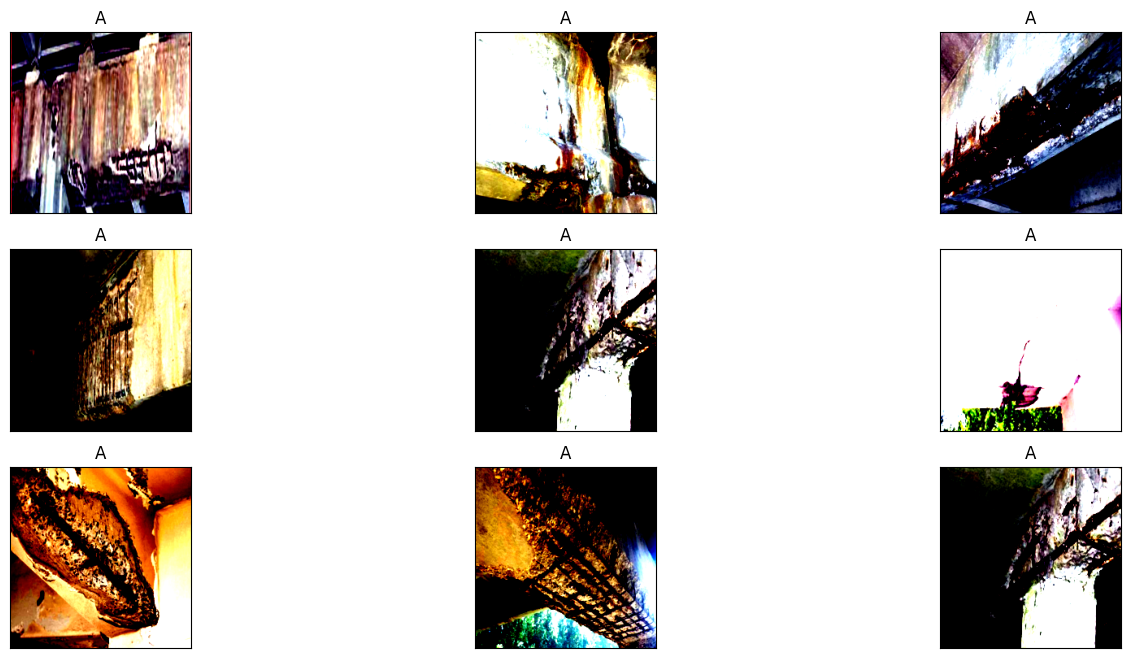

In [ ]:
# Showing training images from batch loading
def Show_Train_Images(trainset_show_noaug):
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(17, 8))
    index = 0
    for i in range(3):
        for j in range(3):
            axes[i, j].set_title(classes[trainset_show_noaug[index][1]])
            # Convert tensor to numpy
            img = trainset_show_noaug[index][0].permute(1, 2, 0).numpy()
            axes[i, j].imshow(img)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
            index += 1
    plt.show()
    return

Show_Train_Images(full_dataset)

Model definition

In [ ]:
# model_pretrained = models.efficientnet_b0(pretrained=True)

# # Replace classifier head
# num_features = model_pretrained.classifier[1].in_features
# model_pretrained.classifier[1] = nn.Linear(num_features, 3)  # 3 classes
# model_pretrained = model_pretrained.to(device)

model_pretrained = models.convnext_tiny(pretrained=True)
model_pretrained.classifier[2] = nn.Linear(model_pretrained.classifier[2].in_features, 3)
model_pretrained = model_pretrained.to(device)

summary(model_pretrained, (3,224,224))


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.fc_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),  # ↓ Shrinks any input to 4×4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc_block(x)
        return x

model_cnn = SimpleCNN().to(device)
summary(model_cnn, (3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 91.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

Model training

In [ ]:
def train(model, trainloader, valloader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Lists to store metrics for plotting
    # If you don't want to use this, there are plenty website and tools to visualize the training process, ex: TensorBoard, Weights & Biases, etc.
    # Just remember to zip them toghether as you submit the homwork
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_loss = float('inf')

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Wrap trainloader with tqdm for progress bar to make it looks nicer
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            # Get inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update running loss
            running_loss += loss.item()

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        # Calculate epoch statistics for training
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate validation loss
                val_running_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate epoch statistics for validation
        epoch_val_loss = val_running_loss / len(valloader)
        scheduler.step(epoch_val_loss)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Early stopping
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
            patience = 5  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:

              print('Early stopping')
              break

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

    # Restore best model weights
    model.load_state_dict(best_model_weights)
    print('Finished Training')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Evaluation function

In [ ]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0

    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')


    return class_correct, class_total, confusion_matrix

In [ ]:
import gc
import torch

del model_cnn  # or any large variable (e.g. output, loss, etc.)
gc.collect()
torch.cuda.empty_cache()

Train and Save the model

In [ ]:
# print("Starting training...")
# trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
#     model_cnn, train_loader, validation_loader, epochs=50
# )


# Stage 1: Train only the classifier
for param in model_pretrained.features.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model_pretrained.classifier.parameters(), lr=1e-3, weight_decay=1e-4)
print("Stage 1: Training only classifier...")
model_pretrained, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model_pretrained, train_loader, validation_loader, optimizer, epochs=50)

# Stage 2: Fine-tune all layers
print("\nStage 2: Fine-tuning all layers...")
# Unfreeze model parameters
for param in model_pretrained.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model_pretrained.parameters(), lr=1e-4, weight_decay=1e-4)
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model_pretrained, train_loader, validation_loader, optimizer, epochs=50)


Stage 1: Training only classifier...


Epoch [1/50]: 100%|██████████| 39/39 [00:13<00:00,  2.86it/s, accuracy=99.9, loss=0.00953]


Epoch 1/50
Train Loss: 0.0095, Train Acc: 99.92%
Val Loss: 0.2404, Val Acc: 92.31%
------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 39/39 [00:13<00:00,  2.89it/s, accuracy=99.8, loss=0.00818]


Epoch 2/50
Train Loss: 0.0082, Train Acc: 99.76%
Val Loss: 0.2938, Val Acc: 91.03%
------------------------------------------------------------


Epoch [3/50]: 100%|██████████| 39/39 [00:13<00:00,  2.87it/s, accuracy=99.9, loss=0.00852]


Epoch 3/50
Train Loss: 0.0085, Train Acc: 99.92%
Val Loss: 0.2579, Val Acc: 92.31%
------------------------------------------------------------


Epoch [4/50]: 100%|██████████| 39/39 [00:14<00:00,  2.71it/s, accuracy=100, loss=0.00509]


Epoch 4/50
Train Loss: 0.0051, Train Acc: 100.00%
Val Loss: 0.3117, Val Acc: 92.31%
------------------------------------------------------------


Epoch [5/50]: 100%|██████████| 39/39 [00:13<00:00,  2.88it/s, accuracy=100, loss=0.00496]


Epoch 5/50
Train Loss: 0.0050, Train Acc: 100.00%
Val Loss: 0.3899, Val Acc: 92.31%
------------------------------------------------------------


Epoch [6/50]: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s, accuracy=99.7, loss=0.014]


Epoch 6/50
Train Loss: 0.0140, Train Acc: 99.68%
Val Loss: 0.2359, Val Acc: 92.31%
------------------------------------------------------------


Epoch [7/50]: 100%|██████████| 39/39 [00:13<00:00,  2.90it/s, accuracy=99.8, loss=0.0108]


Epoch 7/50
Train Loss: 0.0108, Train Acc: 99.76%
Val Loss: 0.2435, Val Acc: 91.03%
------------------------------------------------------------


Epoch [8/50]: 100%|██████████| 39/39 [00:13<00:00,  2.91it/s, accuracy=99.9, loss=0.00729]


Epoch 8/50
Train Loss: 0.0073, Train Acc: 99.92%
Val Loss: 0.2367, Val Acc: 91.03%
------------------------------------------------------------


Epoch [9/50]: 100%|██████████| 39/39 [00:13<00:00,  2.90it/s, accuracy=100, loss=0.00304]


Epoch 9/50
Train Loss: 0.0030, Train Acc: 100.00%
Val Loss: 0.2339, Val Acc: 91.03%
------------------------------------------------------------


Epoch [10/50]: 100%|██████████| 39/39 [00:13<00:00,  2.87it/s, accuracy=99.8, loss=0.00576]


Epoch 10/50
Train Loss: 0.0058, Train Acc: 99.76%
Val Loss: 0.2812, Val Acc: 92.31%
------------------------------------------------------------


Epoch [11/50]: 100%|██████████| 39/39 [00:13<00:00,  2.88it/s, accuracy=100, loss=0.00516]


Epoch 11/50
Train Loss: 0.0052, Train Acc: 100.00%
Val Loss: 0.2354, Val Acc: 91.03%
------------------------------------------------------------


Epoch [12/50]: 100%|██████████| 39/39 [00:13<00:00,  2.91it/s, accuracy=99.8, loss=0.00774]


Epoch 12/50
Train Loss: 0.0077, Train Acc: 99.84%
Val Loss: 0.3307, Val Acc: 91.03%
------------------------------------------------------------


Epoch [13/50]: 100%|██████████| 39/39 [00:13<00:00,  2.89it/s, accuracy=100, loss=0.0037]


Epoch 13/50
Train Loss: 0.0037, Train Acc: 100.00%
Val Loss: 0.2510, Val Acc: 91.03%
------------------------------------------------------------


Epoch [14/50]: 100%|██████████| 39/39 [00:13<00:00,  2.91it/s, accuracy=100, loss=0.00395]


Early stopping
Finished Training

Stage 2: Fine-tuning all layers...


Epoch [1/50]: 100%|██████████| 39/39 [00:28<00:00,  1.39it/s, accuracy=98.9, loss=0.0393]


Epoch 1/50
Train Loss: 0.0393, Train Acc: 98.87%
Val Loss: 0.5062, Val Acc: 87.18%
------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 39/39 [00:27<00:00,  1.40it/s, accuracy=98.6, loss=0.0412]


Epoch 2/50
Train Loss: 0.0412, Train Acc: 98.63%
Val Loss: 0.4568, Val Acc: 88.46%
------------------------------------------------------------


Epoch [3/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.6, loss=0.00693]


Epoch 3/50
Train Loss: 0.0069, Train Acc: 99.60%
Val Loss: 0.2316, Val Acc: 89.74%
------------------------------------------------------------


Epoch [4/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.9, loss=0.00419]


Epoch 4/50
Train Loss: 0.0042, Train Acc: 99.92%
Val Loss: 0.4153, Val Acc: 91.03%
------------------------------------------------------------


Epoch [5/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.8, loss=0.00705]


Epoch 5/50
Train Loss: 0.0071, Train Acc: 99.76%
Val Loss: 0.4597, Val Acc: 89.74%
------------------------------------------------------------


Epoch [6/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.1, loss=0.022]


Epoch 6/50
Train Loss: 0.0220, Train Acc: 99.12%
Val Loss: 0.7219, Val Acc: 87.18%
------------------------------------------------------------


Epoch [7/50]: 100%|██████████| 39/39 [00:28<00:00,  1.38it/s, accuracy=99.4, loss=0.0216]


Epoch 7/50
Train Loss: 0.0216, Train Acc: 99.36%
Val Loss: 0.1977, Val Acc: 89.74%
------------------------------------------------------------


Epoch [8/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.7, loss=0.00846]


Epoch 8/50
Train Loss: 0.0085, Train Acc: 99.68%
Val Loss: 0.1365, Val Acc: 94.87%
------------------------------------------------------------


Epoch [9/50]: 100%|██████████| 39/39 [00:27<00:00,  1.40it/s, accuracy=99.4, loss=0.0127]


Epoch 9/50
Train Loss: 0.0127, Train Acc: 99.44%
Val Loss: 0.1820, Val Acc: 91.03%
------------------------------------------------------------


Epoch [10/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=100, loss=0.00163]


Epoch 10/50
Train Loss: 0.0016, Train Acc: 100.00%
Val Loss: 0.2707, Val Acc: 91.03%
------------------------------------------------------------


Epoch [11/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.9, loss=0.00222]


Epoch 11/50
Train Loss: 0.0022, Train Acc: 99.92%
Val Loss: 0.2575, Val Acc: 94.87%
------------------------------------------------------------


Epoch [12/50]: 100%|██████████| 39/39 [00:27<00:00,  1.41it/s, accuracy=99.5, loss=0.0128]


Epoch 12/50
Train Loss: 0.0128, Train Acc: 99.52%
Val Loss: 0.3905, Val Acc: 88.46%
------------------------------------------------------------


Epoch [13/50]: 100%|██████████| 39/39 [00:27<00:00,  1.39it/s, accuracy=99.9, loss=0.00346]


Early stopping
Finished Training


In [ ]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)

    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []

    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')

    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()

    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

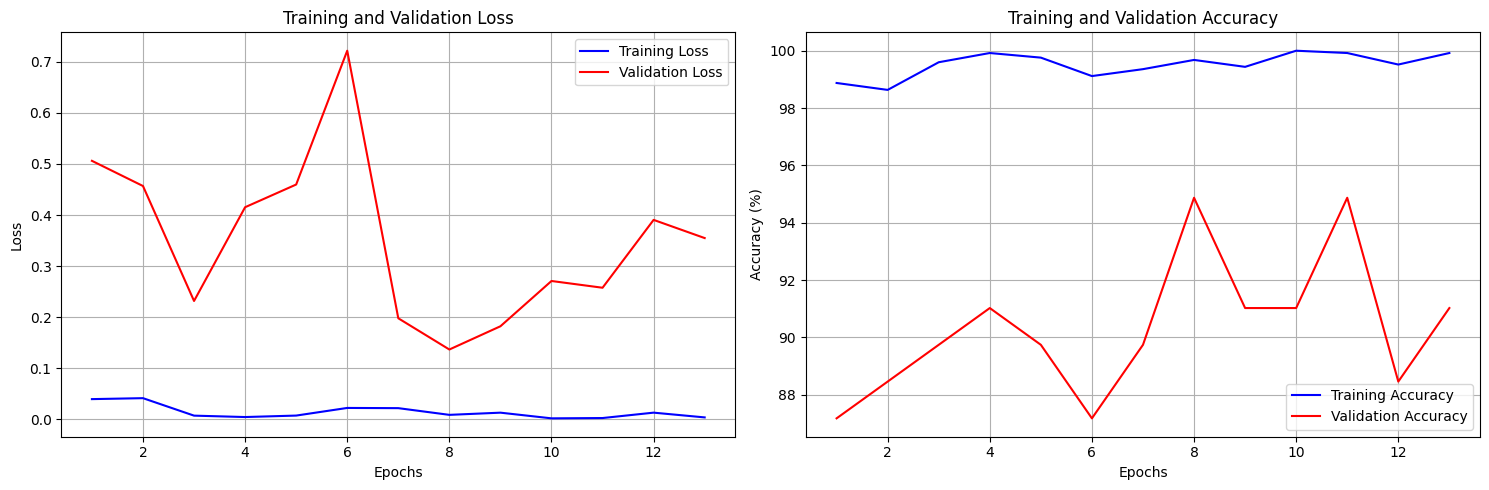

Training metrics plot saved as 'training_metrics.png'


In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

Save model

In [ ]:
def Save_Model():
    torch.save(model_pretrained.state_dict(), '/content/drive/MyDrive/model_pretrained_new.pth')
    print("Model saved successfully!")
    return

def Load_Model():
    model_pretrained.load_state_dict(torch.load('/content/drive/MyDrive/model_simplecnn_2.pth'))
    model_pretrained.eval()
    print("Model loaded successfully!")
    return

In [ ]:
Save_Model()

Model saved successfully!


Output predicted test data

In [ ]:
import os
# === Set paths ===
test_folder_path = "/content/drive/MyDrive/dataset_beam/test"
model_path = "/content/drive/MyDrive/model_simplecnn_2.pth"
output_csv_path = "/content/drive/MyDrive/submission.csv"
file_extension = ".jpg"
idx_to_class = {0: "A", 1: "B", 2: "C"}


# === Load model ===
model_pretrained.to(device)
model_pretrained.eval()

# === Define image transform (same as training) ===
mean, std = compute_mean_std('/content/drive/MyDrive/dataset_beam/beam_damage')
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

# === Prepare output storage ===
predictions = []

# === Loop through test images ===
def count_images_in_dir(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    return sum(1 for file in os.listdir(directory) if file.lower().endswith(image_extensions))

# Example usage
image_dir = '/content/drive/MyDrive/dataset_beam/test'
num_images = count_images_in_dir(image_dir)
print(f"Number of images in folder: {num_images}")

for img_id in tqdm(range(1, num_images+1)):
    img_name = f"{img_id}{file_extension}"
    img_path = os.path.join(test_folder_path, img_name)

    try:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model_pretrained(img_tensor)
            _, predicted = torch.max(output.data, 1)
            label = predicted.item()

        predictions.append((img_id, idx_to_class[label]))

    except Exception as e:
        print(f"❗ Error with image {img_name}: {e}")
        predictions.append((img_id, "error"))

# === Save to CSV ===
predictions.sort(key=lambda x: x[0])
df = pd.DataFrame(predictions, columns=["ID", "class"])
df.to_csv("predictions.csv", index=False)

print("✅ Done! Predictions saved to predictions.csv")

Found 389 images.


Computing mean & std: 100%|██████████| 389/389 [00:02<00:00, 163.90it/s]


Number of images in folder: 100


100%|██████████| 100/100 [00:02<00:00, 45.32it/s]

✅ Done! Predictions saved to predictions.csv
